In [1]:
from QAOA import QAOArunner
from MaxCutProblem import MaxCutProblem
import params
from rustworkx.visualization import mpl_draw as draw_graph
from load_data import load_graph_from_csv

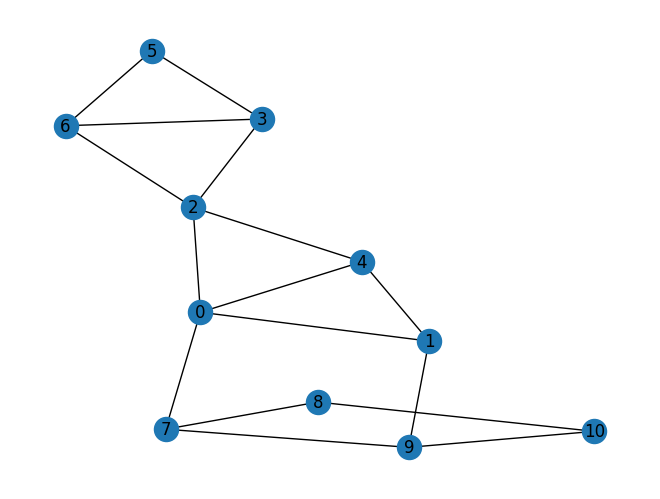

In [2]:
problem = MaxCutProblem()
#graph = problem.get_graph(params.graph_size, create_random=True,random_weights=True)
graph = load_graph_from_csv('data/11_nodes_links_scand.csv')
draw_graph(graph, with_labels=True)

In [3]:
import warnings
from QAOA import QAOArunner
quantum = QAOArunner(graph=graph, 
                     simulation=True,
                     param_initialization= 'gaussian',
                     qaoa_variant='normal', 
                     optimizer='COBYLA',
                     warm_start=False,
                     test_hamil = True
                     )

quantum.build_circuit()
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    quantum.run()
quantum.draw_circuit()

Num qubits:  11
Cost operator type:  <class 'qiskit.quantum_info.operators.operator.Operator'>
Cost operator:  Operator([[ 508.+0.j,    0.+0.j,    0.+0.j, ...,    0.+0.j,    0.+0.j,
              0.+0.j],
          [   0.+0.j, -496.+0.j,    0.+0.j, ...,    0.+0.j,    0.+0.j,
              0.+0.j],
          [   0.+0.j,    0.+0.j, -495.+0.j, ...,    0.+0.j,    0.+0.j,
              0.+0.j],
          ...,
          [   0.+0.j,    0.+0.j,    0.+0.j, ..., 6505.+0.j,    0.+0.j,
              0.+0.j],
          [   0.+0.j,    0.+0.j,    0.+0.j, ...,    0.+0.j, 6504.+0.j,
              0.+0.j],
          [   0.+0.j,    0.+0.j,    0.+0.j, ...,    0.+0.j,    0.+0.j,
           9508.+0.j]],
         input_dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2), output_dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2))
Mixer operator:  Operator([[0.+0.j, 1.+0.j, 1.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
          [1.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
          [1.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0

In [10]:
from solver import Solver



solver = Solver(graph)
quantum.compare_solutions(solver.solve())


Result quantum [0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0] Objective value:  10
Result input (classical) [1.0, 0, 0, 1.0, 0, 0, 0, 0, 1.0, 1.0, 0] Objective Value:  12.0
Same solution False
Same objective function value:  False


In [5]:
quantum.get_prob_distribution()

c:\Users\torbj\AppData\Local\Programs\Python\Python310\lib\site-packages\qiskit\providers\fake_provider\generic_backend_v2.py:963: RuntimeWarning: Aer not found using BasicSimulator and no noise
  warnings.warn("Aer not found using BasicSimulator and no noise", RuntimeWarning)


{1292: 5, 46: 23, 504: 17, 1868: 6, 1214: 1, 1104: 6, 1885: 6, 859: 8, 578: 11, 533: 8, 1518: 17, 1560: 6, 950: 7, 575: 7, 517: 2, 1737: 11, 1230: 31, 1988: 4, 658: 2, 1558: 4, 1784: 6, 1462: 20, 1567: 6, 90: 12, 1447: 7, 902: 20, 1162: 12, 638: 14, 1478: 7, 668: 17, 13: 29, 43: 8, 1317: 16, 664: 10, 94: 10, 2024: 3, 454: 28, 208: 9, 2032: 6, 2038: 3, 1909: 10, 572: 5, 830: 12, 510: 6, 1696: 12, 1508: 2, 695: 6, 377: 13, 1155: 11, 184: 2, 1617: 9, 1029: 11, 2009: 9, 497: 12, 478: 13, 802: 17, 1681: 7, 462: 48, 1286: 12, 329: 13, 1047: 10, 276: 7, 369: 15, 841: 29, 520: 9, 526: 9, 1354: 8, 1780: 2, 2007: 1, 670: 12, 1571: 1, 1357: 13, 535: 6, 1042: 6, 684: 2, 1386: 17, 338: 3, 57: 2, 1401: 22, 225: 3, 1108: 10, 1365: 7, 228: 9, 817: 11, 1520: 3, 1983: 1, 270: 5, 1774: 10, 409: 15, 50: 18, 62: 4, 622: 9, 898: 16, 1188: 4, 1019: 9, 288: 14, 1012: 5, 1649: 4, 2012: 8, 1550: 7, 466: 2, 784: 12, 1881: 11, 145: 19, 781: 6, 1461: 8, 742: 17, 1021: 31, 1880: 1, 973: 20, 2010: 33, 1669: 10, 79: 

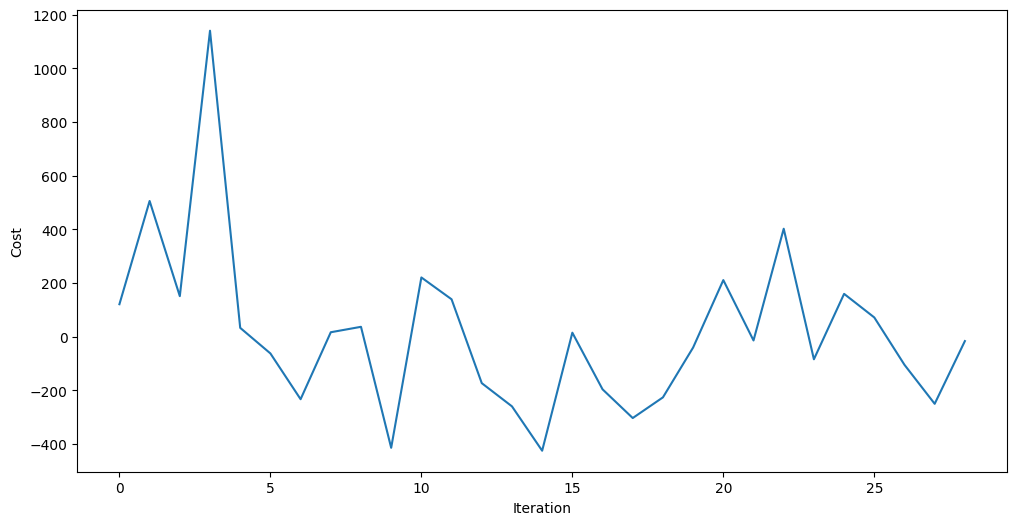

In [6]:
quantum.draw_objective_value()

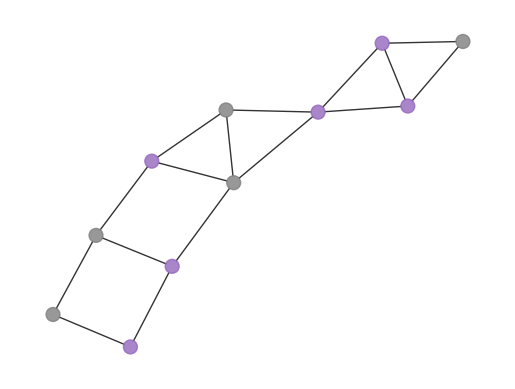

In [7]:
quantum.plot_result()

In [8]:

quantum.compare_solutions(solver.solve())

Result quantum [0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0] Objective value:  10
Result input (classical) [1.0, 0, 0, 1.0, 0, 0, 0, 0, 1.0, 1.0, 0] Objective Value:  12.0
Same solution False
Same objective function value:  False


c:\Users\torbj\AppData\Local\Programs\Python\Python310\lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
c:\Users\torbj\AppData\Local\Programs\Python\Python310\lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
c:\Users\torbj\AppData\Local\Programs\Python\Python310\lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
c:\Users\torbj\AppData\Local\Programs\Python\Python310\lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.

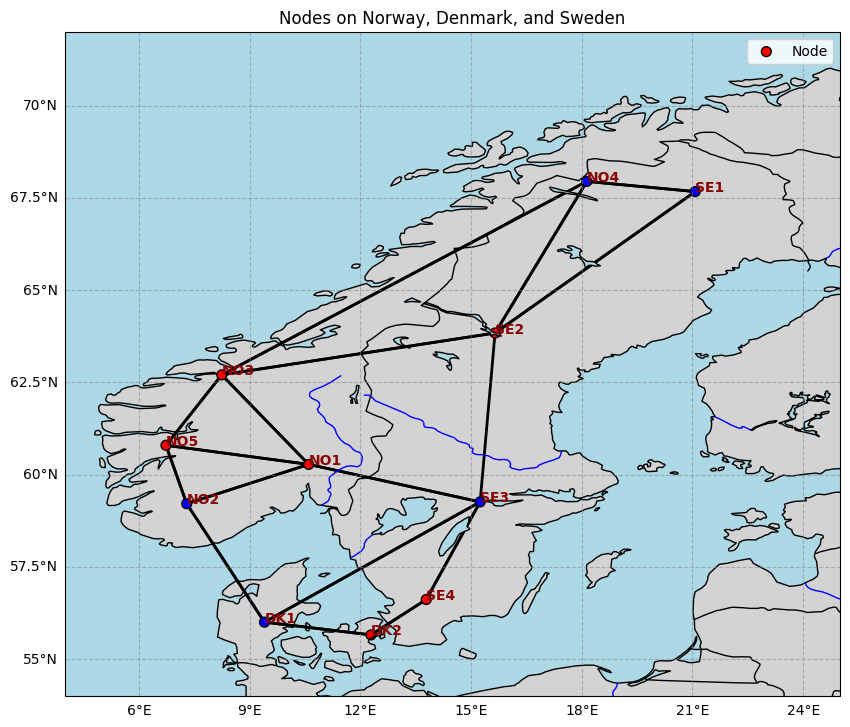

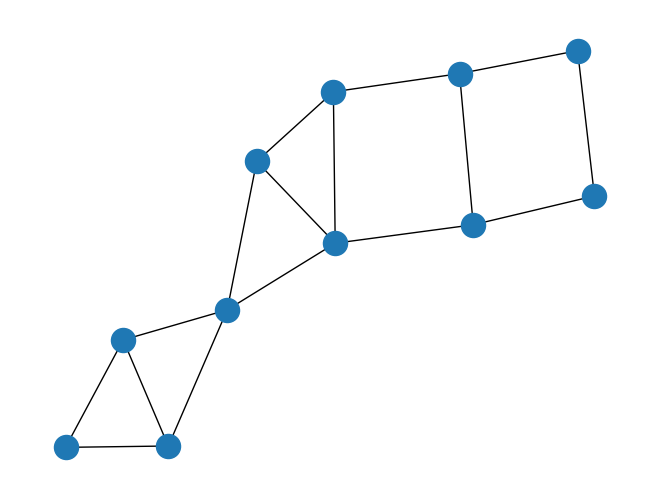

In [9]:
import csv

import numpy as np
import rustworkx as rx
from rustworkx import is_connected
from rustworkx.visualization import mpl_draw as draw_graph
import pandas as pd
import geopandas as gpd
import cartopy.feature as cfeature

def load_graph_from_csv(file_path):


    df = pd.read_csv(file_path,delimiter=';',index_col=0)
    #result = [(row_idx, col_idx, 1) for row_idx, row in enumerate(df.values) for col_idx, value in enumerate(row) if value == 1]
    graph = rx.PyGraph().from_adjacency_matrix(df.values.astype(np.float64))
    draw_graph(graph) 
    return graph

def load_edges_verbose(file_path):
    df = pd.read_csv(file_path,delimiter=';',index_col=0)
    result = [(row, col, 1) for (row, col), value in df.stack().items() if value == 1]
    return result

import cartopy.crs as ccrs
import matplotlib.pyplot as plt

def draw_nodes_on_cartopy(file_path, bitstring=None):
    
    df = pd.read_csv(file_path, delimiter=';')
    edges = load_edges_verbose('data/11_nodes_links_scand.csv')
    
    # Rename the first column
    df.rename(columns={df.columns[0]: 'name'}, inplace=True)
    # Set up a GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['y'], df['x']))

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

    # Add map features
    ax.set_extent([4, 25, 54, 72], crs=ccrs.PlateCarree())  # Set the extent to cover Norway, Denmark, Sweden
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
    ax.add_feature(cfeature.COASTLINE, edgecolor='black')
    ax.add_feature(cfeature.LAKES, facecolor='lightblue', edgecolor='black')
    ax.add_feature(cfeature.RIVERS, edgecolor='blue')
    gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
  
    # Plot nodes on the map
    
    
    for start_label, end_label, weight in edges:
        start_coords = (df[df['name']==start_label]['y'], df[df['name']==start_label]['x'])
        end_coords = (df[df['name']==end_label]['y'], df[df['name']==end_label]['x'])
        ax.plot(
            [start_coords[0], end_coords[0]],  # x-coordinates (longitudes)
            [start_coords[1], end_coords[1]],  # y-coordinates (latitudes)
            color='black', linewidth=1 + weight, transform=ccrs.PlateCarree(), zorder=1
        )
    if bitstring is not None:
        colors = ['red' if bit == 1 else 'blue' for bit in bitstring]
    else:
        colors = 'red'
    
    gdf.plot(ax=ax, color=colors, markersize=50, transform=ccrs.PlateCarree(), edgecolor='black', label='Node')

    for idx, row in gdf.iterrows():
        ax.text(row.geometry.x + 0.005, row.geometry.y, row['name'], transform=ccrs.PlateCarree(),
                ha='left', fontsize=10, color='darkred', fontweight='bold')

    
    plt.legend()
    plt.title("Nodes on Norway, Denmark, and Sweden")
    plt.show()
draw_nodes_on_cartopy('data/11_nodes_coords_scand.csv', bitstring=[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1])


load_graph_from_csv('data/11_nodes_links_scand.csv')


